In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical
from torch.distributions.independent import Independent
from lightning_data_modules.SyntheticDataset import SyntheticDataModule
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from lightning_modules.FokkerPlanckModel import FokkerPlanckModel
from lightning_modules.ConservativeSdeGenerativeModel import ConservativeSdeGenerativeModel
from models.fcn_potential import FCN_Potential
from models.fcn import FCN
from models.utils import get_score_fn
from utils import compute_divergence, compute_grad, compute_curl, generate_grid, extract_vector_field, fisher_divergence
from plot_utils import plot_log_energy
import sde_lib
import pickle

In [10]:
config_path = 'logs/ksphere/n_5/ve_sig_0.01_4.0/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
ckpt_path = "logs/ksphere/n_5/ve_sig_0.01_4.0/checkpoints/best/last.ckpt"

In [11]:
def sample(ckpt_path, sampling_config):
    from sampling.unconditional import get_sampling_fn
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 1000   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [12]:
config.model

checkpoint_path: null
dropout: 0.0
ema_rate: 0.9999
hidden_layers: 3
hidden_nodes: 512
name: fcn
num_scales: 1000
scale_by_sigma: false
sigma_max: 4.0
sigma_min: 0.01
state_size: 100

In [13]:
samples = sample(ckpt_path,config)

100%|██████████| 1000/1000 [00:29<00:00, 34.32it/s]


In [17]:
print(torch.linalg.norm(samples, dim=1).min().item())
print(torch.linalg.norm(samples, dim=1).max().item())
print(torch.linalg.norm(samples, dim=1).mean().item())

0.06643018126487732
1.9529656171798706
0.5657761096954346


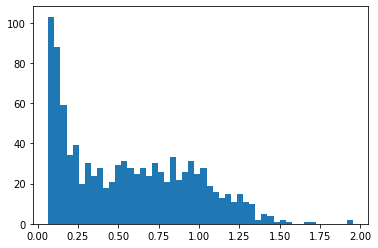

In [16]:
norms=torch.linalg.norm(samples, dim=1).numpy()
plt.hist(norms, bins=50)
plt.show()

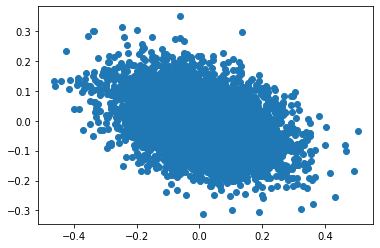

In [21]:
from matplotlib import pyplot as plt
plt.scatter(samples[:,0], samples[:,10])

In [29]:
config

data:
  ambient_dim: 100
  create_dataset: false
  data_samples: 50000
  datamodule: KSphere
  dim: 100
  manifold_dim: 10
  noise_std: 0
  num_channels: 0
  shape:
  - 100
  split:
  - 0.8
  - 0.1
  - 0.1
  use_data_mean: false
device: !!python/object/apply:torch.device
- cpu
eval:
  batch_size: 512
  begin_ckpt: 50
  bpd_dataset: test
  callback: null
  enable_bpd: false
  enable_loss: true
  enable_sampling: true
  end_ckpt: 96
  num_samples: 50000
  workers: 4
logging:
  envery_timedelta: !!python/object/apply:datetime.timedelta
  - 0
  - 60
  - 0
  every_n_epochs: 1000
  log_name: ve_512
  log_path: logs/ksphere/
  top_k: 5
model:
  beta_max: 25
  beta_min: 0.1
  checkpoint_path: null
  dropout: 0.0
  ema_rate: 0.9999
  hidden_layers: 3
  hidden_nodes: 512
  name: fcn
  num_scales: 1000
  scale_by_sigma: false
  sigma_max: 4
  sigma_min: 0.01
  state_size: 100
optim:
  beta1: 0.9
  eps: 1.0e-08
  grad_clip: 1.0
  lr: 2.0e-05
  optimizer: Adam
  warmup: 5000
  weight_decay: 0
sampl